## TP 3 IMA 201 : Segmentation

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import skimage as sk
from scipy import ndimage
from scipy import signal
from skimage import io
from skimage import filters
import mrlab as mr

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle
from time import time
from skimage.io import imread

import cv2

from skimage import data
from skimage import io as skio
from skimage.filters import threshold_otsu

import skimage.morphology as morpho  
import skimage.feature as skf
from scipy import ndimage as ndi


In [14]:
plt.close('all')

### Partie 1 : Détection de contours

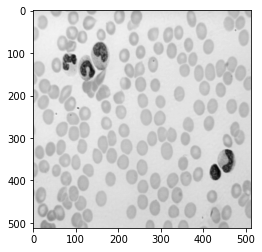

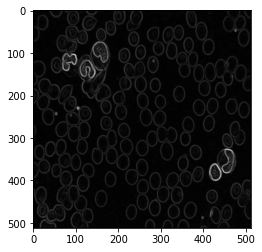

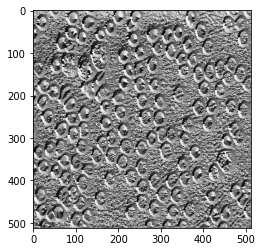

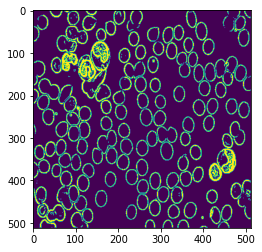

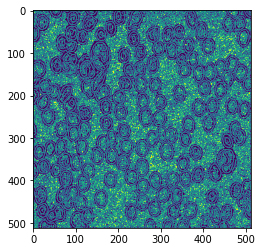

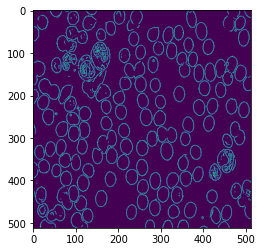

In [10]:
ima=io.imread('cell.tif')
sigma=0
seuilnorme=0.15


gfima=filters.gaussian(ima,sigma)

plt.figure('Image originale')
plt.imshow(ima, cmap='gray')

#plt.figure('Image filtrée (passe-bas)')
#plt.imshow(gfima, cmap='gray')

gradx=mr.sobelGradX(gfima)
grady=mr.sobelGradY(gfima)  
      
#plt.figure('Gradient horizontal')
#plt.imshow(gradx, cmap='gray')

#plt.figure('Gradient vertical')
#plt.imshow(grady, cmap='gray')

norme=np.sqrt(gradx*gradx+grady*grady)

    
plt.figure('Norme du gradient')
plt.imshow(norme, cmap='gray')

direction=np.arctan2(grady,gradx)
    
plt.figure('Direction du Gradient')
plt.imshow(direction, cmap='gray')


contoursnorme =(norme>seuilnorme) 


plt.figure('Norme seuillée')
plt.imshow(255*contoursnorme)


contours=np.uint8(mr.maximaDirectionGradient(gradx,grady))

plt.figure('Maxima du gradient dans la direction du gradient')
plt.imshow(255*contours)


valcontours=(norme>seuilnorme)*contours
      
plt.figure()
plt.imshow(255*valcontours)
plt.show()

#### Filtre de Deriche

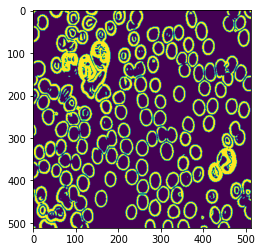

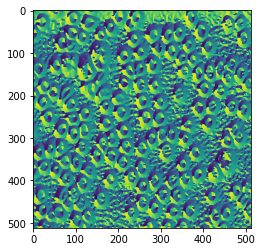

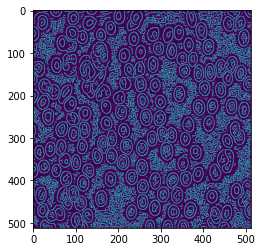

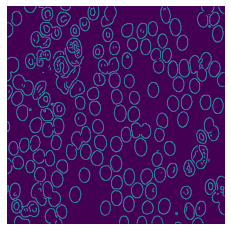

In [15]:
alpha=1
seuilnorme=10
ima=io.imread('cell.tif')


gradx=mr.dericheGradX(mr.dericheSmoothY(ima,alpha),alpha)
grady=mr.dericheGradY(mr.dericheSmoothX(ima,alpha),alpha)  

   
#plt.figure('Image originale')
#plt.imshow(ima, cmap='gray')

#plt.figure('Gradient horizontal')
#plt.imshow(gradx, cmap='gray')

#plt.figure('Gradient vertical')
#plt.imshow(grady, cmap='gray')

norme=np.sqrt(gradx*gradx+grady*grady)

#plt.figure('Norme du gradient')
#plt.imshow(norme, cmap='gray')

contoursnorme =(norme>seuilnorme) 

plt.figure('Norme seuillée')
plt.imshow(255*contoursnorme)

#io.imsave('norme.tif',np.uint8(norme))

nl,nc=gradx.shape
direction=np.arctan2(np.ravel(grady),np.ravel(gradx));

direction=np.reshape(direction,(nl, -1))
direction=255*direction/2/math.pi

plt.figure('Direction du gradient')
plt.imshow(direction)

io.imsave('direction.tif',np.uint8(direction))

contours=np.uint8(mr.maximaDirectionGradient(gradx,grady))

plt.figure('Contours')
plt.imshow(255*contours)


valcontours=(norme>seuilnorme)*contours
      
plt.figure('Contours normés')
plt.axis("off")
plt.imshow(255*valcontours)

#io.imsave('contours.tif',np.uint8(255*valcontours))


### Laplacien

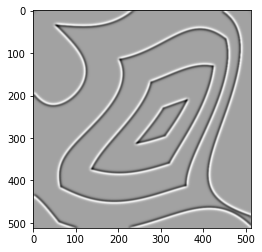

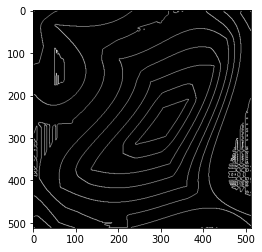

In [32]:
ima=io.imread('pyramide.tif')
alpha=1

gradx=mr.dericheGradX(mr.dericheSmoothY(ima,alpha),alpha)
grady=mr.dericheGradY(mr.dericheSmoothX(ima,alpha),alpha)  

gradx2=mr.dericheGradX(mr.dericheSmoothY(gradx,alpha),alpha)
grady2=mr.dericheGradY(mr.dericheSmoothX(grady,alpha),alpha)  

  

#plt.figure('Image originale')
#plt.imshow(ima, cmap='gray')


lpima=gradx2+grady2

plt.figure('Laplacien')
plt.imshow(lpima, cmap='gray')


posneg=(lpima>=0)

#plt.figure('Laplacien binarisé -/+')
#plt.imshow(255*posneg, cmap='gray')

nl,nc=ima.shape
contours=np.uint8(np.zeros((nl,nc)))


for i in range(1,nl):
    for j in range(1,nc):
        if (((i>0) and (posneg[i-1,j] != posneg[i,j])) or
            ((j>0) and (posneg[i,j-1] != posneg[i,j]))):
            contours[i,j]=255
            
   
plt.figure('Contours')
plt.imshow(contours, cmap='gray')
              
#io.imsave('contours.tif',np.uint8(255*valcontours))

  

### Seuillage avec hysteresis

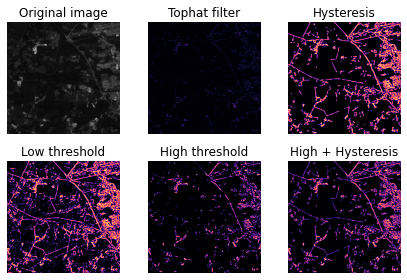

In [42]:
def tophat(im,rayon):
    se=morpho.square(rayon)
    ero=morpho.erosion(im,se)
    dil=morpho.dilation(ero,se)
    tophat=im-dil
    return tophat
    
fig, ax = plt.subplots(nrows=2, ncols=3)

ima = skio.imread('spot.tif')
rayon=5
top=tophat(ima,rayon)

low = 2
high = 7


lowt = (top > low).astype(int)
hight = (top > high).astype(int)
hyst = filters.apply_hysteresis_threshold(top, low, high)


ax[0, 0].imshow(ima, cmap='gray')
ax[0, 0].set_title('Original image')

ax[0, 1].imshow(top, cmap='magma')
ax[0, 1].set_title('Tophat filter')

ax[1, 0].imshow(lowt, cmap='magma')
ax[1, 0].set_title('Low threshold')

ax[1, 1].imshow(hight, cmap='magma')
ax[1, 1].set_title('High threshold')

ax[0, 2].imshow(hyst, cmap='magma')
ax[0, 2].set_title('Hysteresis')

ax[1, 2].imshow(hight + hyst, cmap='magma')
ax[1, 2].set_title('High + Hysteresis')

for a in ax.ravel():
    a.axis('off')

plt.tight_layout()

plt.show()


### K means

Fitting model on a small sub-sample of the data
done in 0.027s.
Predicting color indices on the full image (k-means)
done in 0.001s.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/zl/xsmxp9z51bg9zdlvjzrwvxg40000gn/T/ipykernel_25871/2320894508.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  image[i][j] = codebook[labels[label_idx]]


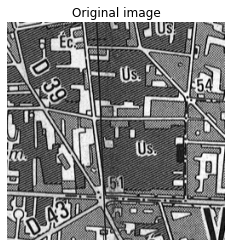

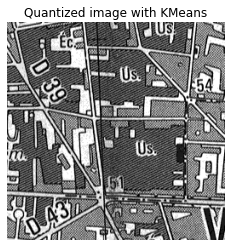

In [11]:
n_class = 10

ima=imread('carte.tif')
# Convert to floats instead of the default 8 bits integer coding. Dividing by
# 255 is important so that plt.imshow behaves works well on float data (need to
# be in the range [0-1])
ima = np.array(ima, dtype=np.float64) / 255

# Load Image and transform to a 2D numpy array.
w, h = original_shape = tuple(ima.shape)
d = 1
image_array = np.reshape(ima, (w * h, d))

print("Fitting model on a small sub-sample of the data")
t0 = time()
image_array_sample = shuffle(image_array, random_state=0)[:1000]
kmeans = KMeans(n_clusters=n_class, random_state=0).fit(image_array_sample)
print("done in %0.3fs." % (time() - t0))

# Get labels for all points
print("Predicting color indices on the full image (k-means)")
t0 = time()
labels = kmeans.predict(image_array)
print("done in %0.3fs." % (time() - t0))

def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    image = np.zeros((w, h))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

# Display all results, alongside original image
plt.figure(1)
plt.clf()
plt.axis('off')
plt.title('Original image')
plt.imshow(ima,cmap='gray')

plt.figure(2)
plt.clf()
plt.axis('off')
plt.title('Quantized image with KMeans')
plt.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h),cmap='gray')
plt.show()

### K means avec images en couleur

Fitting model on a small sub-sample of the data
done in 0.048s.
Predicting color indices on the full image (k-means)
done in 0.004s.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


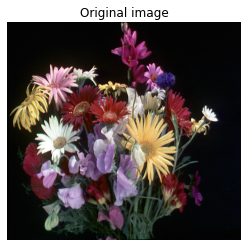

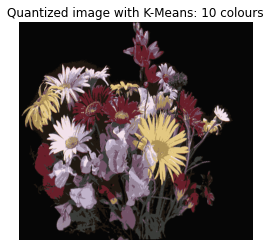

In [9]:
n_colors = 10

ima = imread("fleur.tif")

# Convert to floats instead of the default 8 bits integer coding. Dividing by
# 255 is important so that plt.imshow behaves works well on float data (need to
# be in the range [0-1])
ima = np.array(ima, dtype=np.float64) / 255

# Load Image and transform to a 2D numpy array.
w, h, d = original_shape = tuple(ima.shape)
assert d == 3
image_array = np.reshape(ima, (w * h, d))

print("Fitting model on a small sub-sample of the data")
t0 = time()
image_array_sample = shuffle(image_array, random_state=0)[:1000]
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)
print("done in %0.3fs." % (time() - t0))

# Get labels for all points
print("Predicting color indices on the full image (k-means)")
t0 = time()
labels = kmeans.predict(image_array)
print("done in %0.3fs." % (time() - t0))

def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

# Display all results, alongside original image
plt.figure(1)
plt.clf()
plt.axis('off')
plt.title('Original image')
plt.imshow(ima)

plt.figure(2)
plt.clf()
plt.axis('off')
plt.title('Quantized image with K-Means: %i colours' %n_colors)
plt.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))
plt.show()


### Otsu

128
129


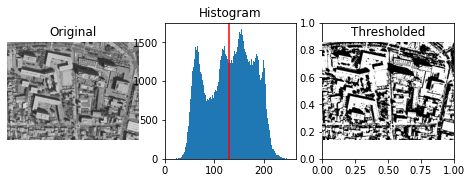

In [18]:
def histogram(im):
    
    nl,nc=im.shape
    
    hist=np.zeros(256)
    
    for i in range(nl):
        for j in range(nc):
            hist[im[i][j]]=hist[im[i][j]]+1
            
    for i in range(256):
        hist[i]=hist[i]/(nc*nl)
        
    return(hist)
    
    
def otsu_thresh(im):
    
    h=histogram(im)
    
    m=0
    for i in range(256):
        m=m+i*h[i]
    
    maxt=0
    maxk=0
    
    
    for t in range(256):
        w0=0
        w1=0
        m0=0
        m1=0
        for i in range(t):
            w0=w0+h[i]
            m0=m0+i*h[i]
        if w0 > 0:
            m0=m0/w0
        
        for i in range(t,256):
            w1=w1+h[i]
            m1=m1+i*h[i]
        if w1 > 0:   
            m1=m1/w1
        
        k=w0*w1*(m0-m1)*(m0-m1)    
        
        if k > maxk:
            maxk=k
            maxt=t
            
            
    thresh=maxt
        
    return(thresh)


image = skio.imread('vincennes.tif')
thresh = threshold_otsu(image)
print(thresh)
binary = image > thresh

thresh=otsu_thresh(image)
binary = image > thresh
print(thresh)

fig, axes = plt.subplots(ncols=3, figsize=(8, 2.5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

bins=np.max(image)-np.min(image)+1

ax[1].hist(image.ravel(), bins=bins)
ax[1].set_title('Histogram')
ax[1].axvline(thresh, color='r')

ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

plt.show()


### Otsu à trois classes

102 158


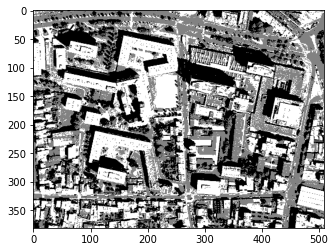

In [48]:
def histogram(im):
    
    nl,nc=im.shape
    
    hist=np.zeros(256)
    
    for i in range(nl):
        for j in range(nc):
            hist[im[i][j]]=hist[im[i][j]]+1
            
    for i in range(256):
        hist[i]=hist[i]/(nc*nl)
        
    return(hist)
    
    
def otsu_thresh(im):
    
    h=histogram(im)
    
    m=0
    for i in range(256):
        m=m+i*h[i]
    
    maxt1=0
    maxt2 = 0
    maxk=0
    
    
    for t1 in range(256):

        for t2 in range(256):

            w0=0
            w1=0
            w2=0
            m0=0
            m1=0
            m2=0

            for i in range(t1):
                w0=w0+h[i]
                m0=m0+i*h[i]
            if w0 > 0:
                m0=m0/w0

            for i in range(t1,t2):
                w1=w1+h[i]
                m1=m1+i*h[i]

            if w1 > 0:   
                m1=m1/w1
        
            for i in range(t2,256):
                w2=w2+h[i]
                m2=m2+i*h[i]

            if w2 > 0:   
                m2=m2/w2
        
            k=w0*(m0-m)**2+w1*(m1-m)**2+w2*(m2-m)**2  # Variance interclasse   
        
            if k > maxk:
                maxk=k
                maxt1=t1
                maxt2=t2
            
            
    thresh1,thresh2=maxt1,maxt2
        
    return(thresh1, thresh2)


image = skio.imread('vincennes.tif')

thresh1, thresh2 =otsu_thresh(image)
print(thresh1, thresh2)

three_classes_image = np.zeros(image.shape)

for i in range(image.shape[0]):
    for j in range(image.shape[1]):

        if image[i][j] <= thresh1:
            three_classes_image[i][j] = thresh1//2

        elif image[i][j] > thresh1 and image[i][j] <= thresh2:
            three_classes_image[i][j] = (thresh2+thresh1)//2

        else :
            three_classes_image[i][j] = (255 + thresh2)//2

plt.figure('three classes image')
plt.imshow(three_classes_image, cmap=plt.cm.gray)

### Croissance de régions

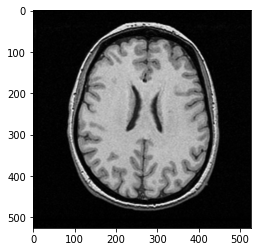

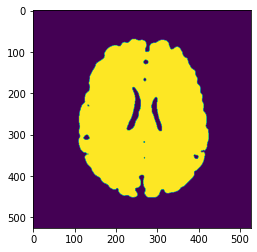

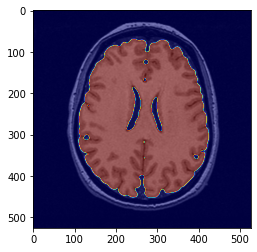

In [4]:
def my_perimeter(im):
    se=morpho.disk(1)
    dil=morpho.dilation(im,se)
    diff=dil-im
    ta=np.nonzero(diff)
    return ta
    

def histogram(im):
    
    nl,nc=im.shape
    
    hist=np.zeros(256)
    
    for i in range(nl):
        for j in range(nc):
            hist[im[i][j]]=hist[im[i][j]]+1
            
    for i in range(256):
        hist[i]=hist[i]/(nc*nl)
        
    return(hist)
    
    
    

im=skio.imread('cerveau.tif')
mask=np.zeros((len(im),len(im[0])))

plt.figure('Image originale')
plt.imshow(im,cmap='gray')
plt.show()



### paramètres
# position du germe initial
y0=100
x0=240
# seuil du prédicat
thresh=5
# voisinage pour le calcul de la moyenne et de l'écart-type locaux
rayon=5

# Masque initial
mask[y0,x0]=255

ext=im[y0-rayon:y0+rayon+1,x0-rayon:x0+rayon+1]
m0=np.mean(ext)
s0=np.std(ext)


# Boucle tant qu'il y a des changements.

modif=1
iter = 0 

while modif >  0:

    iter=iter+1
        
    modif=0

    # Calcul du périmètre du masque
    
    per=my_perimeter(mask)

    # Boucle sur les points du périmètre

    for i in range (0 , len(per[0])):

        y=per[0][i]
        x=per[1][i]
        ext=im[y-rayon:y+rayon+1,x-rayon:x+rayon+1]
        m=np.mean(ext)
        s=np.std(ext)

        # Prédicat

        if np.abs(m0-m) < thresh * s0 :
            mask[y][x]=255
            modif=1

    #cv2.imshow('frame',mask)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break


plt.figure('masque')
plt.imshow(mask)
plt.show()


se=morpho.disk(1)
dil=morpho.dilation(mask,se)
diff=dil-mask

plt.figure('superposition')
plt.imshow(im, cmap='gray') # I would add interpolation='none'
plt.imshow(mask, cmap='jet', alpha=0.5) # interpolation='none'
plt.show()